#이 문서를 따로 첨부한 이유는 ARP 히트맵 figure 때문이다.

In [106]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta

# AFSNT 불러오기

In [0]:
AFSNT = pd.read_csv('/content/gdrive/My Drive/test_colab/AFSNT.csv', engine = "python")

# 데이터 전처리

In [0]:
AFSNT=AFSNT.rename(columns={'SDT_YY':'Year','SDT_MM':'Month','SDT_DD':'Day'})
AFSNT['Date']=pd.to_datetime(AFSNT.loc[:, ['Year','Month','Day']])
AFSNT=AFSNT.drop(['Year','Month','Day','SDT_DY'],axis=1)

afsnt_count=AFSNT.groupby(['Date','ARP']).size().to_frame()
afsnt=pd.merge(AFSNT,afsnt_count,on=['Date','ARP'])
AFSNT = afsnt.rename(columns={0:'flights'})

AFSNT=AFSNT[AFSNT.FLO!='C']
AFSNT=AFSNT[AFSNT.FLO!='D']
AFSNT=AFSNT[AFSNT.FLO!='E']
AFSNT=AFSNT[AFSNT.FLO!='G']
AFSNT=AFSNT[AFSNT.FLO!='K']

AFSNT=AFSNT[AFSNT.CNL=='N']

AFSNT=AFSNT.loc[:,['Date','ARP', 'ODP', 'FLO','FLT','REG', 'AOD','IRR', 'STT', 'ATT', 'DLY', 'DRR', 'CNL',
       'CNR','flights']]

In [0]:
STT_hour=AFSNT['STT'].str.split(':').str.get(0).astype('float64')
ATT_hour=AFSNT['ATT'].str.split(':').str.get(0).astype('float64')

In [0]:
def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute

AFSNT['STT_minute']=AFSNT['STT'].apply(getValuebyminute)
arp_sort=AFSNT.sort_values(by=['Date','ARP','STT_minute'])
sttlen=(max(arp_sort['STT_minute'])-min(arp_sort['STT_minute']))/20
#print(sttlen)

def TTto60(TT):
    return int(TT/sttlen)

arp_sort['STT_category']=arp_sort['STT_minute'].apply(TTto60)

timetable=pd.DataFrame()
timetable=arp_sort.groupby(['Date','ARP','STT_category']).size()

windowsize=5
timetable=timetable.to_frame()
AFSNT=pd.merge(left=arp_sort,right=timetable,on=['Date','ARP','STT_category'])
AFSNT = AFSNT.rename(columns={0:'slots'})

In [0]:
over_time_idx=AFSNT.loc[(STT_hour>ATT_hour)&(AFSNT.DLY=='Y'),:].index

AFSNT['STT_detail']=pd.to_datetime(AFSNT['Date'].astype('str')+' '+AFSNT['STT'])
AFSNT['ATT_detail']=pd.to_datetime(AFSNT['Date'].astype('str')+' '+AFSNT['ATT'])

AFSNT.loc[over_time_idx,'ATT_detail']=AFSNT.loc[over_time_idx,'ATT_detail']+pd.DateOffset(days=1)

In [0]:
AFSNT['Interval']=AFSNT['ATT_detail']-AFSNT['STT_detail']
AFSNT=AFSNT.rename(columns={'Interval':'INT'})
AFSNT['INT']=pd.to_timedelta(AFSNT['INT'],unit='m').astype('timedelta64[m]')

In [0]:
def weekdayn(Date):
  return Date.weekday()
def gethour(STT):
  hour,minute=STT.split(':')
  return hour
def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute
def mysum(a,b):
  return a+b
AFSNT['Weekday']=AFSNT['Date'].apply(weekdayn)
AFSNT['STT_minute']=AFSNT['STT'].apply(getValuebyminute)
AFSNT['ATT_minute']=np.sum(AFSNT.loc[:,['STT_minute','INT']],axis=1)

In [0]:
AFSNT['Hour']=AFSNT['STT_detail'].dt.hour

In [0]:
AFSNT_irr=AFSNT[AFSNT['IRR']=='Y']

In [117]:
STTtime = AFSNT.groupby(['Hour', 'DLY']).size().unstack()
STTtime['Total'] = STTtime['N'] + STTtime['Y']
STTtime = STTtime.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], :].reset_index()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [118]:
STTtime_irr = AFSNT_irr.groupby(['Hour', 'DLY']).size().unstack()
STTtime_irr['Total'] = STTtime_irr['N'] + STTtime_irr['Y']
STTtime_irr= STTtime_irr.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], :].reset_index()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
AFSNT=AFSNT.loc[AFSNT['IRR']=='N'] 
AFSNT['INT']=AFSNT['INT'].apply(lambda x : 91.0 if x>91.0 else x)
AFSNT['INT']=AFSNT['INT'].apply(lambda x : 0.0 if x<0.0 else x)

# 공항 EDA

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


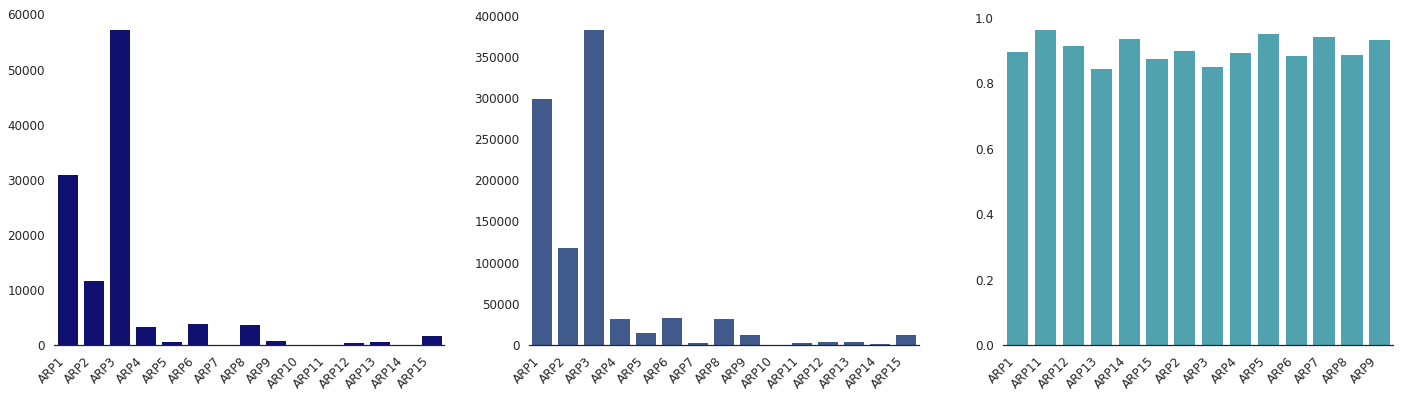

In [120]:
#항공편 수
df_arp = AFSNT.groupby(['ARP', 'DLY']).size().unstack()
df_arp['Total'] = df_arp['N'] + df_arp['Y']
df_arp = df_arp.loc[['ARP1', 'ARP2', 'ARP3', 'ARP4', 'ARP5', 'ARP6', 'ARP7', 'ARP8', 'ARP9', 'ARP10', 'ARP11', 'ARP12', 'ARP13', 'ARP14', 'ARP15'], :].reset_index()

#비율
df_arp2 = AFSNT.groupby(['ARP', 'DLY']).size().unstack().transpose()
df_arp2 = df_arp2.div(df_arp2.sum()).fillna(0).transpose().reset_index()
df_arp2['Total'] = df_arp2['N'] + df_arp2['Y']

sns.set_style("white")
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))
fig.autofmt_xdate(rotation = 45)

sns.barplot(x = df_arp['ARP'], y = df_arp['Y'], color = 'navy', ax = ax1); ax1.set_xlabel(""); ax1.set_ylabel("") 
sns.barplot(x = df_arp['ARP'], y = df_arp['Total'], color = "#335699", ax = ax2); ax2.set_xlabel(""); ax2.set_ylabel("")
sns.barplot(x = df_arp2['ARP'], y = df_arp2['N'], color = '#40adbf', ax = ax3); ax3.set_xlabel(""); ax3.set_ylabel("")


sns.despine(left=True)
for item in ([ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)
for item in ([ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(12)
for item in ([ax3.xaxis.label, ax3.yaxis.label] + ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(12)    
plt.tight_layout(pad = 2)

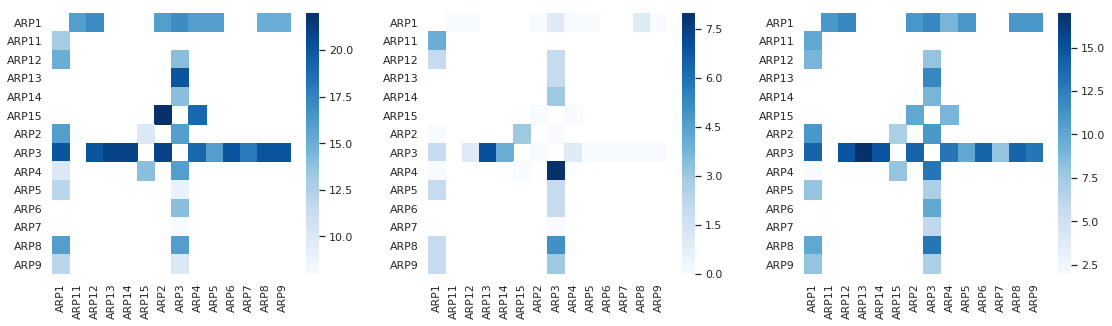

In [121]:
# 히트맵그래프
AFSNT_d =AFSNT[AFSNT['AOD'] == 'D']
AFSNT_a = AFSNT[AFSNT['AOD'] == 'A']

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (16, 5))
sns.heatmap(AFSNT_d.groupby(['ARP', 'ODP'])['INT'].median().unstack(), cmap = "Blues", ax = ax1); ax1.set_xlabel(""); ax1.set_ylabel("");
sns.heatmap(AFSNT_a.groupby(['ARP', 'ODP'])['INT'].median().unstack(), cmap = "Blues", ax = ax2); ax2.set_xlabel(""); ax2.set_ylabel(""); #ax2.set_xticklabels([]); ax2.set_yticklabels([]);
sns.heatmap(AFSNT.groupby(['ARP', 'ODP'])['INT'].median().unstack(), cmap = 'Blues', ax = ax3); ax3.set_xlabel(""); ax3.set_ylabel("");

plt.tight_layout(pad = 2)
plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


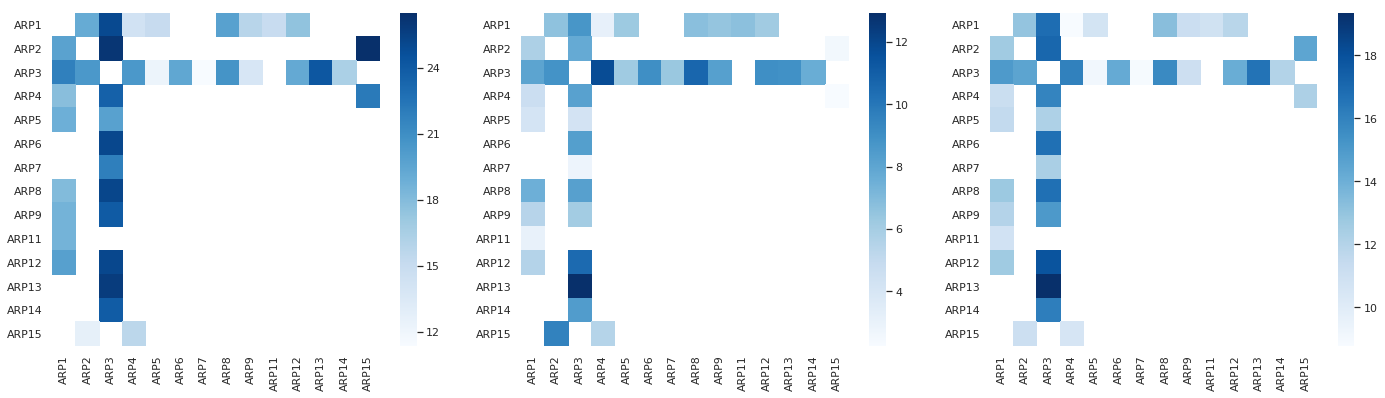

In [122]:
# 히트맵그래프
AFSNT_d1 =AFSNT[AFSNT['AOD'] == 'D']
AFSNT_a1 = AFSNT[AFSNT['AOD'] == 'A']

d1 = AFSNT_d1.loc[:, ['ARP','ODP','INT','DLY']]
a1 = AFSNT_a1.loc[:, ['ARP','ODP','INT','DLY']]
afsnt=AFSNT.loc[:, ['ARP','ODP','INT','DLY']]



a=['ARP1','ARP2','ARP3','ARP4','ARP5','ARP6','ARP7','ARP8','ARP9','ARP10','ARP11','ARP12','ARP13','ARP14','ARP15']

d1['ARP'] = d1['ARP'].astype('category', categories=a, ordered=True)
d1['ODP'] = d1['ODP'].astype('category', categories=a, ordered=True)


a1['ARP'] = a1['ARP'].astype('category', categories=a, ordered=True)
a1['ODP'] = a1['ODP'].astype('category', categories=a, ordered=True)

afsnt['ARP'] = afsnt['ARP'].astype('category', categories=a, ordered=True)
afsnt['ODP'] = afsnt['ODP'].astype('category', categories=a, ordered=True)

heatmap2_data1 = pd.pivot_table(d1,values='INT', index=['ODP'], columns='ARP')
heatmap2_data2 = pd.pivot_table(a1,values='INT', index=['ODP'], columns='ARP')
heatmap2_data3 = pd.pivot_table(afsnt,values='INT', index=['ODP'], columns='ARP')
ax1.set_ylabel("");

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))
sns.heatmap(heatmap2_data1, cmap="Blues",ax=ax1); ax1.set_xlabel(""); ax1.set_ylabel("");
sns.heatmap(heatmap2_data2, cmap="Blues",ax=ax2); ax2.set_xlabel(""); ax2.set_ylabel("");
sns.heatmap(heatmap2_data3, cmap="Blues",ax=ax3); ax3.set_xlabel(""); ax3.set_ylabel("");


plt.tight_layout(pad = 2)
plt.show()